# Exploration of GDELT Dataset

## Executive Summary

< Problem statement>

< Introduce dataset>

< Introduce models used>

< Present important results>

< Communicate relevant insights>

## Introduction

< Stated the source of the data and introduced it to provide a complete
context for understanding the rest of the report>

< Has an explicit and clearly stated problem statement>

< Has an explicit and convincing motivation statement>

## Data Collection and Description

< – Described the data format and provided some relevant metadata that
allow the reader to clearly understand the data processing code>

In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import dask.dataframe as dd
import dask.bag as db
from dask.delayed import delayed
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask.diagnostics import ProgressBar

## Exploratory Data Analysis

< Performed complete exploratory data analysis that are fully explained>

< All figures are properly labeled and captioned>

## Methodology

< Complete methodology stated, described and justified>

## Results

< results presented are clean, robust and relevant that will allow a strong
answer or solution to the stated problem>

< explicit answer to the stated problem and presented interesting insights on
that can be traced back to the methods and discussion results >

## References

## Acknowledgements

## Test Code

In [ ]:
# set to run Dask commands in this "cluster"
client = Client('10.233.29.219:8786')

In [2]:
# check the contents of the folder
path = '/mnt/data/public/gdeltv2/*'
glob.glob(path)

['/mnt/data/public/gdeltv2/20170101190000.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170131134500.gkg.csv.zip',
 '/mnt/data/public/gdeltv2/20170210224500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170213203000.gkg.csv.zip',
 '/mnt/data/public/gdeltv2/20170215044500.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170225004500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170407133000.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170412044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170418044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170427171500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170506113000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170511183000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170516070000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170518223000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170528044500.mentions.CSV.zip',
 '/mnt/data/public/gdeltv2/20170528213000.export.CSV.zip',
 '/mnt/data/public/gdeltv2/20170602141500.gkg.

In [3]:
# we see three kinds of files
# let's open the contents one by one

# we define sample sets
f1 = ['/mnt/data/public/gdeltv2/20170611004500.mentions.CSV.zip']
f2 = ['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']
f3 = ['/mnt/data/public/gdeltv2/20170611004500.gkg.csv.zip']

# we import the progress bar
# pbar = ProgressBar()
# pbar.register()

# we load mentions.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f1]
df = dd.from_delayed(dfs)
print(f1)
display(df.head().T)

# we load export.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f2]
df = dd.from_delayed(dfs)
print(f2)
display(df.head().T)

# we load gkg.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', engine='python') for fn in f3]
df = dd.from_delayed(dfs)
print(f3)
display(df.head().T)

['/mnt/data/public/gdeltv2/20170611004500.mentions.CSV.zip']


,0,1,2,3,4
0,549285546,549255686,549316095,549316095,663766551
1,20160611023000,20160611001500,20160611053000,20160611053000,20170611004500
2,20170611004500,20170611004500,20170611004500,20170611004500,20170611004500
3,1,1,1,1,1
4,nbcnews.com,nbcnews.com,cbs8.com,kaaltv.com,nbcnews.com
5,http://www.nbcnews.com/news/us-news/jeff-sessi...,http://www.nbcnews.com/news/us-news/jeff-sessi...,http://www.cbs8.com/story/35635737/london-brid...,http://www.KAALtv.com/world/london-bridge-atta...,http://www.nbcnews.com/storyline/isis-uncovere...
6,28,28,6,6,10
7,-1,-1,1174,1149,2894
8,5102,5102,-1,-1,2922
9,5060,5060,1122,1097,2909


['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']


,0,1,2,3,4
0,663766551,663766552,663766553,663766554,663766555
1,20160611,20160611,20160611,20160611,20160611
2,201606,201606,201606,201606,201606
3,2016,2016,2016,2016,2016
4,2016.4411,2016.4411,2016.4411,2016.4411,2016.4411
5,REB,USA,USA,USA,USA
6,SUICIDE BOMBER,UNITED STATES,THE US,UNITED STATES,UNITED STATES
7,nan,USA,USA,USA,USA
8,nan,nan,nan,nan,nan
9,nan,nan,nan,nan,nan


['/mnt/data/public/gdeltv2/20170611004500.gkg.csv.zip']


,0,1,2,3,4
0,20170611004500-0,20170611004500-1,20170611004500-2,20170611004500-3,20170611004500-4
1,20170611004500,20170611004500,20170611004500,20170611004500,20170611004500
2,1,1,1,1,1
3,dailyexcelsior.com,thebusinessjournal.com,therepublic.com,echonews.com.au,borderwatch.com.au
4,http://www.dailyexcelsior.com/ddc-kupwara-insp...,http://www.thebusinessjournal.com/news/constru...,http://www.therepublic.com/2017/06/10/us-comey...,https://www.echonews.com.au/news/going-electri...,http://www.borderwatch.com.au/story/4721481/pe...
5,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan
7,GENERAL_HEALTH;MEDICAL;SOC_POINTSOFINTEREST;SO...,MANMADE_DISASTER_IMPLIED;TAX_FNCACT;TAX_FNCACT...,TAX_FNCACT;TAX_FNCACT_DIRECTOR;LEADER;TAX_FNCA...,MANMADE_DISASTER_IMPLIED;,nan
8,"ECON_STOCKMARKET,1471;TAX_FNCACT_PARAMEDICS,60...","TAX_FNCACT_BUILDER,675;ECON_HOUSING_PRICES,533...","TAX_FNCACT_DEPUTY,4410;TAX_POLITICAL_PARTY_REP...","MANMADE_DISASTER_IMPLIED,224;MANMADE_DISASTER_...",nan
9,"4#Kupwara, Jammu And Kashmir, India#IN#IN12#34...","2#California, United States#US#USCA#36.17#-119...","2#New York, United States#US#USNY#42.1497#-74....","4#Ewingsdale, New South Wales, Australia#AS#AS...","4#Penrith, New South Wales, Australia#AS#AS02#..."


In [4]:
# We see that there are no columns in the dataset
# We found the columns in GDELT website

events_columns = ['GlobalEventID', 'Day', 'MonthYear', 'Year', 'FractionDate',
                  'Actor1Code', 'Actor1Name', 'Actor1CountryCode',
                  'Actor1KnownGroupCode', 'Actor1EthnicCode',
                  'Actor1Religion1Code', 'Actor1Religion2Code',
                  'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code',
                  'Actor2Code', 'Actor2Name', 'Actor2CountryCode',
                  'Actor2KnownGroupCode', 'Actor2EthnicCode',
                  'Actor2Religion1Code', 'Actor2Religion2Code',
                  'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code',
                  'IsRootEvent', 'EventCode', 'EventBaseCode',
                  'EventRootCode', 'QuadClass', 'GoldsteinScale',
                  'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
                  'Actor1Geo_Type', 'Actor1Geo_Fullname',
                  'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code',
                  'Actor1Geo_ADM2Code', 'Actor1Geo_Lat', 'Actor1Geo_Long',
                  'Actor1Geo_FeatureID', 'Actor2Geo_Type',
                  'Actor2Geo_Fullname', 'Actor2Geo_CountryCode',
                  'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code',
                  'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID',
                  'ActionGeo_Type', 'ActionGeo_Fullname',
                  'ActionGeo_CountryCode', 'ActionGeo_ADM1Code',
                  'ActionGeo_ADM2Code', 'ActionGeo_Lat', 'ActionGeo_Long',
                  'ActionGeo_FeatureID', 'DATEADDED', 'SOURCEURL']
gkg_columns = ['GKGRECORDID', 'V2.1DATE', 'V2SOURCECOLLECTIONIDENTIFIER', 'V2SOURCECOMMONNAME',
               'V2DOCUMENTIDENTIFIER', 'V1COUNTS', 'V2.1COUNTS', 'V1THEMES', 'V2ENHANCEDTHEMES',
               'V1LOCATIONS', 'V2ENHANCEDLOCATIONS', 'V1PERSONS', 'V2ENHANCEDPERSONS',
               'V1ORGANIZATIONS', 'V2ENHANCEDORGANIZATIONS', 'V1.5TONE', 'V2.1ENHANCEDDATES',
               'V2GCAM', 'V2.1SHARINGIMAGE', 'V2.1RELATEDIMAGES', 'V2.1SOCIALIMAGEEMBEDS',
               'V2.1SOCIALVIDEOEMBEDS', 'V2.1QUOTATIONS', 'V2.1ALLNAMES', 'V2.1AMOUNTS',
               'V2.1TRANSLATIONINFO', 'V2EXTRASXML']

In [5]:
# We load the datasets again with columns defined above
# We skip mentions since we won't need those data

# we define sample sets
f2 = ['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']
f3 = ['/mnt/data/public/gdeltv2/20170611004500.gkg.csv.zip']

# we import the progress bar
# pbar = ProgressBar()
# pbar.register()

# we load export.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', names=events_columns, engine='python') for fn in f2]
df = dd.from_delayed(dfs)
print(f2)
display(df.head().T)

# we load gkg.CSV.zip into a delayed Pandas dataframe

dfs = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', names=gkg_columns, engine='python') for fn in f3]
df = dd.from_delayed(dfs)
print(f3)
display(df.head().T)

['/mnt/data/public/gdeltv2/20170611004500.export.CSV.zip']


,0,1,2,3,4
GlobalEventID,663766551,663766552,663766553,663766554,663766555
Day,20160611,20160611,20160611,20160611,20160611
MonthYear,201606,201606,201606,201606,201606
Year,2016,2016,2016,2016,2016
FractionDate,2016.4411,2016.4411,2016.4411,2016.4411,2016.4411
Actor1Code,REB,USA,USA,USA,USA
Actor1Name,SUICIDE BOMBER,UNITED STATES,THE US,UNITED STATES,UNITED STATES
Actor1CountryCode,nan,USA,USA,USA,USA
Actor1KnownGroupCode,nan,nan,nan,nan,nan
Actor1EthnicCode,nan,nan,nan,nan,nan


['/mnt/data/public/gdeltv2/20170611004500.gkg.csv.zip']


,0,1,2,3,4
GKGRECORDID,20170611004500-0,20170611004500-1,20170611004500-2,20170611004500-3,20170611004500-4
V2.1DATE,20170611004500,20170611004500,20170611004500,20170611004500,20170611004500
V2SOURCECOLLECTIONIDENTIFIER,1,1,1,1,1
V2SOURCECOMMONNAME,dailyexcelsior.com,thebusinessjournal.com,therepublic.com,echonews.com.au,borderwatch.com.au
V2DOCUMENTIDENTIFIER,http://www.dailyexcelsior.com/ddc-kupwara-insp...,http://www.thebusinessjournal.com/news/constru...,http://www.therepublic.com/2017/06/10/us-comey...,https://www.echonews.com.au/news/going-electri...,http://www.borderwatch.com.au/story/4721481/pe...
V1COUNTS,nan,nan,nan,nan,nan
V2.1COUNTS,nan,nan,nan,nan,nan
V1THEMES,GENERAL_HEALTH;MEDICAL;SOC_POINTSOFINTEREST;SO...,MANMADE_DISASTER_IMPLIED;TAX_FNCACT;TAX_FNCACT...,TAX_FNCACT;TAX_FNCACT_DIRECTOR;LEADER;TAX_FNCA...,MANMADE_DISASTER_IMPLIED;,nan
V2ENHANCEDTHEMES,"ECON_STOCKMARKET,1471;TAX_FNCACT_PARAMEDICS,60...","TAX_FNCACT_BUILDER,675;ECON_HOUSING_PRICES,533...","TAX_FNCACT_DEPUTY,4410;TAX_POLITICAL_PARTY_REP...","MANMADE_DISASTER_IMPLIED,224;MANMADE_DISASTER_...",nan
V1LOCATIONS,"4#Kupwara, Jammu And Kashmir, India#IN#IN12#34...","2#California, United States#US#USCA#36.17#-119...","2#New York, United States#US#USNY#42.1497#-74....","4#Ewingsdale, New South Wales, Australia#AS#AS...","4#Penrith, New South Wales, Australia#AS#AS02#..."


In [8]:
# We are ready to load a larger dataset

# we define sample sets = 1 month
f_events = glob.glob('/mnt/data/public/gdeltv2/20180101*.export.CSV.zip')
f_gkg = glob.glob('/mnt/data/public/gdeltv2/20180101*.gkg.csv.zip')

# we import the progress bar
pbar = ProgressBar()
pbar.register()

# we load export.CSV.zip into a delayed Pandas dataframe
dfs_events = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
                            dtype='str', names=events_columns, engine='python') for fn in f_events]
df_events = dd.from_delayed(dfs_events).set_index('GlobalEventID')
print('EVENTS')
display(df_events.head().T)

# # we load gkg.CSV.zip into a delayed Pandas dataframe

# dfs_gkg = [delayed(pd.read_csv)(fn, delimiter='\t', header=None,
#                             dtype='str', names=gkg_columns, engine='python') for fn in f_gkg]
# df_gkg = dd.from_delayed(dfs_gkg).set_index('GlobalEventID')
# print('GLOBAL KNOWLEDGE GRAPH')
# display(df.head().T)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.4s
EVENTS
[########################################] | 100% Completed | 11.2s
[########################################] | 100% Completed | 11.3s


GlobalEventID,719024869,719024870,719024871,719024872,719024873
Day,20170101,20170101,20170101,20170101,20170101
MonthYear,201701,201701,201701,201701,201701
Year,2017,2017,2017,2017,2017
FractionDate,2017.0027,2017.0027,2017.0027,2017.0027,2017.0027
Actor1Code,AGR,AGR,AGR,AGR,AGR
Actor1Name,FARMER,FARMER,FARMER,FARMER,FARMER
Actor1CountryCode,nan,nan,nan,nan,nan
Actor1KnownGroupCode,nan,nan,nan,nan,nan
Actor1EthnicCode,nan,nan,nan,nan,nan
Actor1Religion1Code,nan,nan,nan,nan,nan


In [10]:
type(df_events)
# type(df_gkg)

dask.dataframe.core.DataFrame

In [11]:
# how many entries in events for 1 month
# len(df_events)

In [12]:
# how many entries in gkg for 1 month
# len(df_gkg)

In [13]:
# Interesting data to examine in Events dataset
    # Goldstein score of each country == general stability of the region
    # NumMentions = number of mentions of the event over 15 minutes; importance
    # NumSources = number of sources of event; importance
    # NumArticles =  number of articles of event; importance
    # AvgTone = how positive or how negative the event is
    
    # To be continued

In [15]:
# Check average goldstein score, avgTone of each country/location
# Columns to keep
keep_cols = ['Day', 'GoldsteinScale', 'NumMentions',
             'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long',
            'Actor1Geo_CountryCode']

# Extract the needed data
df_ = df_events[keep_cols]
print("> Selected needed data from Events data.")
print(f"> Type of dataframe {type(df_)}")

> Selected needed data from Events data.
> Type of dataframe <class 'dask.dataframe.core.DataFrame'>


In [22]:
# Get a sample for plotting 
frac = 0.01
df_events_sample = df_.sample(frac=frac).persist()
print(f"> Obtained a {frac} sample for plotting.")
print("> Selected data persisted into workers.")

[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.5s
> Obtained a 0.01 sample for plotting.
> Selected data persisted into workers.


In [17]:
# check data types in sample dataset
df_events_sample.compute().info()

[                                        ] | 0% Completed |  0.1s1s
[########################################] | 100% Completed |  0.2s
<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 719025329 to 719169789
Data columns (total 9 columns):
Day                      94 non-null object
GoldsteinScale           94 non-null object
NumMentions              94 non-null object
NumSources               94 non-null object
NumArticles              94 non-null object
AvgTone                  94 non-null object
Actor1Geo_Lat            94 non-null object
Actor1Geo_Long           94 non-null object
Actor1Geo_CountryCode    94 non-null object
dtypes: object(9)
memory usage: 7.3+ KB


In [23]:
# Convert numerical datapoints to floats
to_conv =['Day', 'GoldsteinScale', 'NumMentions',
             'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long']
df_events_sample[to_conv] = df_events_sample[to_conv].astype(float).compute()
print("> Converted numerical data to float")

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
> Converted numerical data to float


In [24]:
# check data types in sample dataset
df_events_sample.compute().info()

[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.8s
<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 719025541 to 719170078
Data columns (total 9 columns):
Day                      891 non-null float64
GoldsteinScale           891 non-null float64
NumMentions              891 non-null float64
NumSources               891 non-null float64
NumArticles              891 non-null float64
AvgTone                  891 non-null float64
Actor1Geo_Lat            782 non-null float64
Actor1Geo_Long           782 non-null float64
Actor1Geo_CountryCode    891 non-null object
dtypes: float64(8), object(1)
memory usage: 69.6+ KB


In [25]:
# Plot the longitudes and latitudes color coded according to Goldstein value

# Drop null values
df_events_sample = df_events_sample.dropna(subset=['GoldsteinScale', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_CountryCode']).persist()
print("> Null values dropped.")
print("> Sampled dataframe persisted")

# Persist first
y = df_events_sample['Actor1Geo_Lat'].to_dask_array(lengths=True).persist()
x = df_events_sample['Actor1Geo_Long'].to_dask_array(lengths=True).persist()
c = df_events_sample['GoldsteinScale'].to_dask_array(lengths=True).persist()
countries = df_events_sample['Actor1Geo_CountryCode'].to_dask_array(lengths=True).persist()

[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.6s
> Null values dropped.
> Sampled dataframe persisted
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  

[                                        ] | 0% Completed |  0.1s1s
[########################################] | 100% Completed |  0.2s
[                                        ] | 0% Completed |  0.1s1s
[########################################] | 100% Completed |  0.2s
[                                        ] | 0% Completed |  0.1s1s
[########################################] | 100% Completed |  0.2s


(-174.49074696904955,
 191.41574696904956,
 -47.35071543180584,
 70.35071543180584)

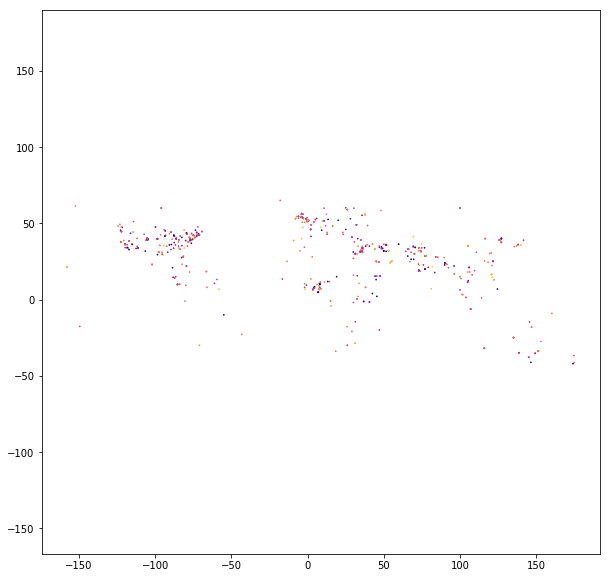

In [26]:
# Goldstein values vs Latitude and Longitude
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, c=c, marker='o', s=0.5, cmap='plasma')
plt.axis('equal')

In [27]:
# Goldstein Chloropleth
import plotly.plotly as py
import plotly.figure_factory as ff

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(1, 12, len(colorscale) - 1))

fig = ff.create_choropleth(
    fips=countries, values=c,
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='AAA',
    legend_title='AAAA'
)
py.iplot(fig, filename='choropleth_full_Goldstein')



ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
pip install geopandas==0.3.0
pip install pyshp==1.2.10
pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
conda install plotly
conda install geopandas
```

In [ ]:
# MAKE NEW ENVIRONMENT WITH GEOPANDAS

In [ ]:
# Goldstein Bubble chart on map

In [ ]:
# Goldstein Score bar charts


In [ ]:
# DO THE SAME FOR PHILIPPINES

In [ ]:
type(df_events_2)